In [43]:
from libraries import lib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from libraries.NeuralStates import *

In [44]:
# import numpy.random as npr
# import random

# class SparseStateVector:
#     """
#     Container class for dictionary (self.values) with keys of integer states
#     and values being complex amplitude of psi
#     """
#     def __init__(self):
#         self.values = {}
#         self.normalized = False

#     def TFIM_multiply(psi, N, J, Gamma):
#         """
#         Returns new sparse vector representing H|psi>
#         """
#         prod = SparseStateVector()
#         for state in psi.values:
#             jtotal = 0
#             for site in range(N - 1):
#                 jtotal += J if ((state >> site) ^ (state >> site + 1)) & 1 else -J
#             jtotal += J if ((state >> (N - 1)) ^ (state >> 0)) & 1 else -J 
#             prod.values[state] = jtotal * psi.values[state]
        
#         for state in psi.values:
#             for site in range(N):
#                 flipped_state = state ^ (1 << site)
#                 prod.values[flipped_state] = prod.values.get(flipped_state, 0) - Gamma * psi.values[state]
#         return prod

#     def inner_product(v1, v2):
#         """
#         Returns <v1|v2> for two SparseStateVectors
#         """
#         prod = 0
#         for s in v1.values:
#             if s in v2.values:
#                 prod += torch.conj(v1.values[s]) * v2.values[s]
#         return prod

#     def TFIM_expectation_from_sparse(psi, N, J, Gamma):
#         """
#         Returns <psi|H|psi>/<psi|psi> for SparseStateVector psi
#         """
#         # do H|psi> then <psi| (H|psi>)
#         hpsi = SparseStateVector.TFIM_multiply(psi, N, J, Gamma)
#         exp = SparseStateVector.inner_product(psi, hpsi)
#         if not psi.normalized:
#             mag2 = SparseStateVector.inner_product(psi, psi)
#             return (exp / mag2).real
#         return exp.real

#     def normalize(self):
#         """
#         Normalizes values
#         """
#         mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
#         for s in self.values:
#             self.values[s] = self.values[s] / mag
#         self.normalized = True

#     def to_prob_distribution(self, N):
#         """
#         Returns 1D list representing real probability distribution
#         """
#         if not self.normalized:
#             mag2 = sum(abs(self.values[s]) ** 2 for s in self.values)
#             return [(abs(self.values.get(s, 0)) ** 2 / mag2).item() for s in range(0, 2 ** N)]
#         return [abs(self.values.get(s, 0)) ** 2 for s in range(0, 2 ** N)]
    
#     def to_dense_vector(self, N):
#         """
#         Returns 1D list of dense representation
#         """
#         if not self.normalized:
#             mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
#             return [(self.values.get(s, 0) / mag).item() for s in range(0, 2 ** N)]
#         return [self.values.get(s, 0).item() for s in range(0, 2 ** N)]

# class UniformNeuralState(SparseStateVector):
#     def __init__(self, N, model, output_to_psi, num_samples):
#         """
#         Initializes sparse vector values

#         Args:
#             N (int): number of qubits
#             model: torch model representing psi(x), which returns complex amplitude given integer state
#             output_to_psi (function): takes in output of model to compute complex amplitude
#             num_samples (int): number of unique integer samples to take
#             informed (bool): whether to guarantee sample first and last states
#         """
#         super().__init__()
#         self.samples = num_samples
#         self.distribution = {}
#         self.list = []
#         self.nn_output = {}
#         def psi(x):
#             tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
#             nn_output = model(tens)
#             return output_to_psi(nn_output)[0], nn_output[0]
#         if num_samples >= 2 ** N:
#             for state in range(2 ** N):
#                 self.distribution[state] = 1
#                 self.list.append(state)
#                 self.values[state], self.nn_output[state] = psi(state)
#         else:
#             sampled_states = set()
#             for _ in range(num_samples):
#                 x = random.getrandbits(N)
#                 while x in sampled_states:
#                     x = random.getrandbits(N)
#                 sampled_states.add(x)
#                 self.distribution[x] = self.distribution.get(x, 0) + 1
#                 self.list.append(x)
#             for state in sampled_states:
#                 self.values[state], self.nn_output[state] = psi(state)

# class MHNeuralState(SparseStateVector):
#     def __init__(self, N, model, output_to_psi, x_func, x0, num_samples, burnin = 0, lag = 0):
#         """
#         Initializes distribution of samples and vector values

#         Args:
#             N (int): number of qubits
#             model: torch model representing psi(x), which returns complex amplitude given integer state
#             output_to_psi (function): takes in output of model to compute complex amplitude
#             x_func (function): takes in state x and generates proposal x*
#             x0 (int): intger state to begin sampling
#             num_samples (int): number of proposal x* generated
#             burnin (int): number of samples to throw away before accepting first sample
#             lag (int): number of samples to throw away in-between accepting samples
#             informed (bool): whether to guarantee sample first and last states
#         """
#         # uses arbitrary x_func for MH sampling
#         super().__init__()
#         self.distribution = {}
#         self.list = []
#         self.nn_output = {}
#         self.samples = num_samples
#         def psi(x):
#             tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
#             nn_output = model(tens)
#             return output_to_psi(nn_output)[0], nn_output[0]
#         num_uniform = burnin + num_samples * (lag + 1)
#         rand_uniform = npr.uniform(0, 1, num_uniform)
#         index = 0

#         x = x0
#         psi_val, nn_val = psi(x)
#         self.values[x] = psi_val
#         self.nn_output[x] = nn_val
#         for _ in range(burnin):
#             new_x = x_func(x)
#             new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
#             ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
#             if ratio > 1 or ratio > rand_uniform[index]:
#                 x = new_x
#                 psi_val = new_psi_val
#             index += 1
#         for _ in range(num_samples):
#             for _ in range(lag):
#                 new_x = x_func(x)
#                 new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
#                 ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
#                 if ratio > 1 or ratio > rand_uniform[index]:
#                     x = new_x
#                     psi_val = new_psi_val
#                 index += 1
#             new_x = x_func(x)
#             if new_x in self.values: new_psi_val, new_nn_val = self.values[new_x], self.nn_output[new_x]
#             else: new_psi_val, new_nn_val = psi(new_x)
#             ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
#             if ratio > 1 or ratio > rand_uniform[index]:
#                 self.distribution[new_x] = self.distribution.get(new_x, 0) + 1
#                 self.list.append(new_x)
#                 x = new_x 
#                 psi_val = new_psi_val 
#             else: 
#                 self.distribution[x] = self.distribution.get(x, 0) + 1
#                 self.list.append(x)
#             self.values[new_x] = new_psi_val
#             self.nn_output[new_x] = new_nn_val
#             index += 1

In [45]:
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * nn_output[:, 1])
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In [54]:
# only for nn_output = (log(amp), phase)
def generate_eloc_list(sampled_vector, N, J, Gamma, model):
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output

    eloc_values = []
    for basis_state in sampled_vector.list:
        eloc = 0
        output = model_to_output(basis_state)
        for adjacency in lib.generate_adjacencies(basis_state, N):
            output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_prime[0] - output[0] + 1.j * 2 * np.pi * (output_prime[1] - output[1]))
        # eloc += lib.calc_H_elem(N, J, Gamma, basis_state, basis_state)
        eloc_values.append(eloc)
    return eloc_values
def set_gradients(sampled_vector: MHNeuralState, N, J, Gamma, model: nn.Sequential): # also only for log(amp), phase
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    def output_to_log(x):
        return x[0] + 1.j * x[1]

    elocs = {}
    re_grad_logs = {}
    im_grad_logs = {}
    params = [p for p in model.parameters()]
    for basis_state in sampled_vector.distribution:
        eloc = 0
        nn_output = sampled_vector.nn_output[basis_state]
        for adjacency in lib.generate_adjacencies(basis_state, N):
            nn_output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output))
        elocs[basis_state] = eloc.detach()
        
        nn_output[0].backward(retain_graph=True)
        real_grads = [p.grad.clone() for p in params]
        for p in params: p.grad = None
        nn_output[1].backward(retain_graph=True)
        imag_grads = [-p.grad.clone() for p in params]
        re_grad_logs[basis_state] = real_grads
        im_grad_logs[basis_state] = imag_grads

    E_eloc = (sum(sampled_vector.distribution[x] * elocs[x] for x in sampled_vector.distribution) / sampled_vector.samples).real

    for i in range(len(params)):
        E_grad_times_loc = sum((re_grad_logs[x][i] * elocs[x].real - im_grad_logs[x][i] * elocs[x].imag) * \
                               sampled_vector.distribution[x] for x in sampled_vector.distribution) / sampled_vector.samples
        E_grad = sum(re_grad_logs[x][i] * sampled_vector.distribution[x] for x in sampled_vector.distribution) / sampled_vector.samples
        params[i].grad = E_grad_times_loc - E_grad * E_eloc

    return E_eloc

def update_gradients(model, lr):
    with torch.no_grad():
        for p in model.parameters():
            p -= lr * p.grad 


In [55]:
def set_gradients_exact(sampled_vector: MHNeuralState, N, J, Gamma, model: nn.Sequential): # also only for log(amp), phase
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    def output_to_log(x):
        return x[0] + 1.j * x[1]

    elocs = {}
    re_grad_logs = {}
    im_grad_logs = {}
    amp = 0
    params = [p for p in model.parameters()]
    for basis_state in sampled_vector.values:
        eloc = 0
        nn_output = sampled_vector.nn_output[basis_state]
        for adjacency in lib.generate_adjacencies(basis_state, N):
            nn_output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output))
        elocs[basis_state] = eloc.detach()
        
        nn_output[0].backward(retain_graph=True)
        real_grads = [p.grad.clone() for p in params]
        for p in params: p.grad = None
        nn_output[1].backward(retain_graph=True)
        imag_grads = [-p.grad.clone() for p in params]
        re_grad_logs[basis_state] = real_grads
        im_grad_logs[basis_state] = imag_grads

        amp += abs(sampled_vector.values[basis_state]) ** 2

    E_eloc = (sum(abs(sampled_vector.values[x])** 2 * elocs[x] for x in sampled_vector.values) / amp).real

    for i in range(len(params)):
        E_grad_times_loc = sum((re_grad_logs[x][i] * elocs[x].real - im_grad_logs[x][i] * elocs[x].imag) * \
                                abs(sampled_vector.values[x]) ** 2 for x in sampled_vector.values) / amp
        E_grad = sum(re_grad_logs[x][i] * abs(sampled_vector.values[x]) ** 2 for x in sampled_vector.values) / amp
        params[i].grad = E_grad_times_loc - E_grad * E_eloc

    return E_eloc


In [56]:
N=20; J=1; Gamma=1
print(lib.ground_state_energy(Gamma, N))

-25.49098968636475


In [57]:
layers = []
layers.append(nn.Linear(N, 32))
for _ in range(2):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.SELU())
layers.append(nn.Linear(32, 2))
model = nn.Sequential(*layers)

In [58]:
num_epochs = 1000
data_rate = 1
num_samples = 512

In [59]:
epochs = []
energy_data = []
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
for epoch in range(500): # range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    optimizer.zero_grad()
    energy = set_gradients(mh_state, N, J, Gamma, model)
    # energy = set_gradients_exact(mh_state, N, J, Gamma, model)
    optimizer.step()
    # update_gradients(model, 1e-2)
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy)
print(energy_data[-1])
print(min(energy_data))

0 tensor(-20.6701)
1 tensor(-20.9853)
2 tensor(-19.8082)
3 tensor(-19.6521)
4 tensor(-20.9185)
5 tensor(-20.5408)
6 tensor(-19.6978)
7 tensor(-20.7077)
8 tensor(-19.4589)
9 tensor(-19.3513)
10 tensor(-19.9983)
11 tensor(-20.3945)
12 tensor(-20.0055)
13 tensor(-20.5024)
14 tensor(-20.4931)
15 tensor(-21.0210)
16 tensor(-20.1346)
17 tensor(-19.5996)
18 tensor(-19.9392)
19 tensor(-19.9982)
20 tensor(-20.4455)
21 tensor(-19.7273)
22 tensor(-20.6861)
23 tensor(-20.7927)
24 tensor(-21.6812)
25 tensor(-21.5802)
26 tensor(-21.3593)
27 tensor(-21.2973)
28 tensor(-22.2660)
29 tensor(-24.0592)
30 tensor(-23.8077)
31 tensor(-22.8277)
32 tensor(-22.0620)
33 tensor(-22.0509)
34 tensor(-21.1509)
35 tensor(-22.2296)
36 tensor(-23.4357)
37 tensor(-22.5746)
38 tensor(-21.4984)
39 tensor(-23.1928)
40 tensor(-23.0302)
41 tensor(-22.7871)
42 tensor(-24.4480)
43 tensor(-22.9851)
44 tensor(-22.8280)
45 tensor(-22.8728)
46 tensor(-23.5958)
47 tensor(-23.1916)
48 tensor(-24.2297)
49 tensor(-24.4085)
50 tensor(

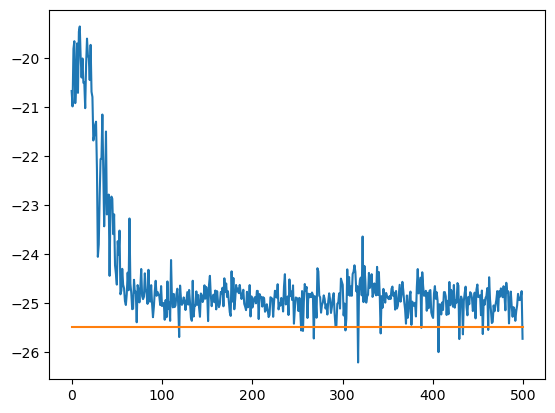

In [60]:
plt.plot(epochs, energy_data)
plt.plot([0, epochs[-1]], 2*[-25.5])
plt.show()

In [61]:
# torch.save(model.state_dict(), 'weird_model_neg_36_GSE.pt') # this is a bug where everything NaNs but the computer thinks GSE is good

In [62]:
gs = lib.model_to_ground_state(model, lib.generate_input_torch(N), log_amp_phase)

KeyboardInterrupt: 

In [43]:
for i in range(2 ** N):
    if not np.isnan(gs[i][0]):
        print(i, gs[i][0])
print('fin')

fin


In [53]:
nn_output_calcs = {}
def model_to_output(x):
    if x in sampled_vector.nn_output:
        return sampled_vector.nn_output[x]
    if x in nn_output_calcs:
        return nn_output_calcs[x]
    tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
    output = model(tens)[0]
    nn_output_calcs[x] = output
    return output
def output_to_log(x):
    return x[0] + 1.j * x[1]
elocs = {}
sampled_vector = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
for basis_state in sampled_vector.distribution:
    eloc = 0
    nn_output = sampled_vector.nn_output[basis_state]
    for adjacency in lib.generate_adjacencies(basis_state, N):
        nn_output_prime = model_to_output(adjacency)
        eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output))
        print(adjacency, lib.calc_H_elem(N, J, Gamma, basis_state, adjacency),  torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output)))
    elocs[basis_state] = eloc.detach()
E_eloc = (sum(sampled_vector.distribution[x] * elocs[x] for x in sampled_vector.distribution) / sampled_vector.samples).real

524289 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
524290 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
524292 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
524296 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
524304 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
524320 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
524352 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
524416 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
524544 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
524800 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
525312 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
526336 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
528384 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
532480 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
540672 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
557056 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
589824 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
655360 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
786432 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
0 -1 tensor(1.+0.j, grad_fn=<ExpBackward0>)
524288 -16 tensor(1.+0.j,

In [55]:
elocs

{524288: tensor(-36.+0.j)}